In [1]:
'''Main'''
import numpy as np
import pandas as pd
import math
from math import sqrt

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

'''Data Prep and Model Evaluation'''
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [2]:
#Train dataset
train_df = pd.read_csv('./Dataset/train.csv')

#Test dataset
test_df = pd.read_csv('./Dataset/test.csv')

In [3]:
train_df.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [4]:
train_df.dtypes

Date            object
Consumption    float64
dtype: object

Now the Date column in train dataset is an object. It will be turned into a datatime type

In [5]:
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%Y/%m/%d')
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [6]:
train_df.dtypes

Date           datetime64[ns]
Consumption           float64
dtype: object

In [7]:
test_df.dtypes

Date    datetime64[ns]
dtype: object

In [8]:
train_df = train_df.set_index('Date')

In [9]:
train_df.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


In [10]:
train_df.isna().sum()

Consumption    0
dtype: int64

In [11]:
train_df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='Date', length=3287, freq=None)

In [12]:
# Add columns with year, month, and weekday name
train_df['Year'] = train_df.index.year
train_df['Month'] = train_df.index.month_name()
train_df['Day'] = train_df.index.day
train_df['Weekday'] = train_df.index.day_name()
# Display a random sampling of 5 rows
train_df.head()

,Consumption,Year,Month,Day,Weekday
Date,,,,,
2006-01-01,1069.184,2006,January,1,Sunday
2006-01-02,1380.521,2006,January,2,Monday
2006-01-03,1442.533,2006,January,3,Tuesday
2006-01-04,1457.217,2006,January,4,Wednesday
2006-01-05,1477.131,2006,January,5,Thursday


In [13]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

<AxesSubplot:xlabel='Date'>

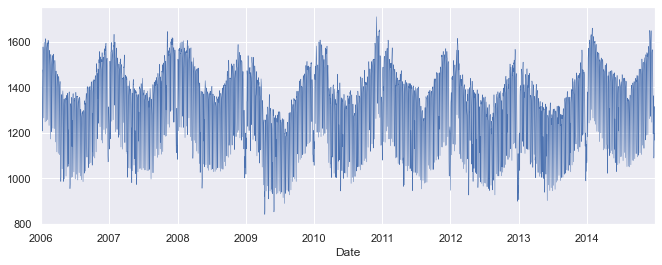

In [14]:
train_df['Consumption'].plot(linewidth=0.5)

Text(0, 0.5, 'Daily Consumption (GWh)')

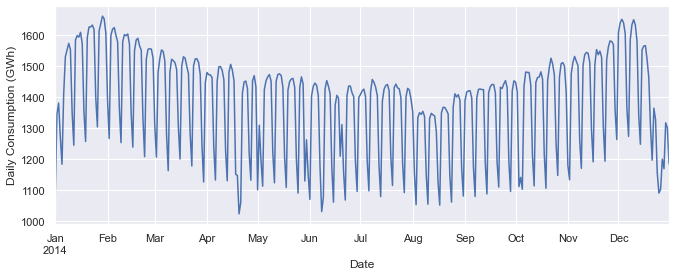

In [15]:
ax = train_df.loc['2014', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)')

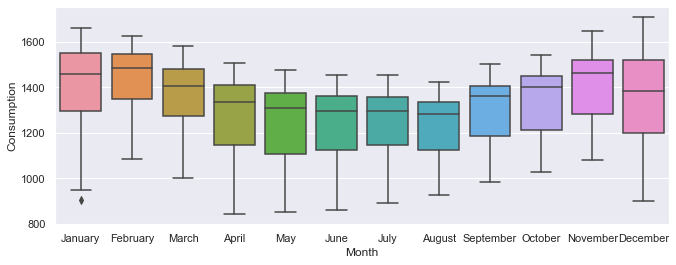

In [16]:
# Group the data by month, to visualize yearly seasonality.
ax = sns.boxplot(x="Month", y="Consumption", data=train_df, dodge=False)

<AxesSubplot:xlabel='Weekday', ylabel='Consumption'>

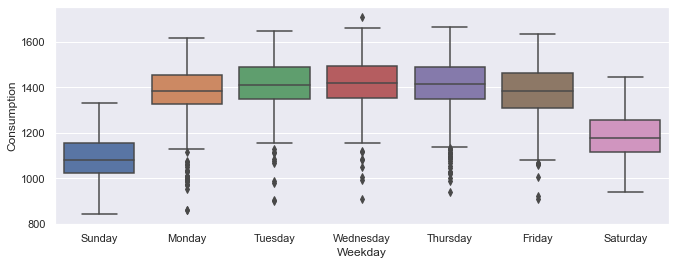

In [17]:
# Grouping the electricity consumption time series by day of the week, to explore weekly seasonality.
sns.boxplot(data=train_df, x='Weekday', y='Consumption')

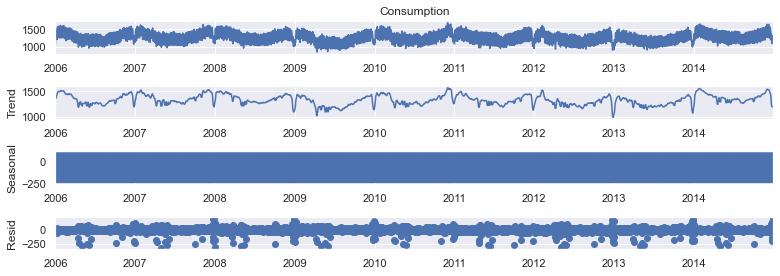

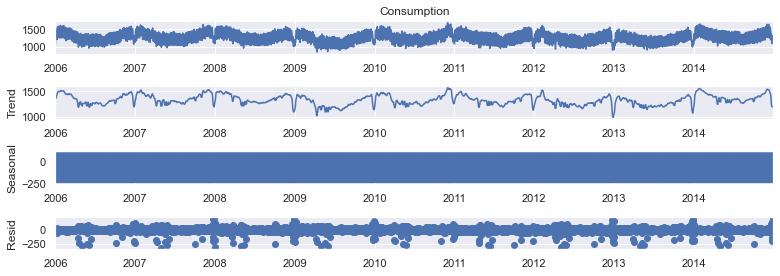

In [18]:
results = seasonal_decompose(train_df['Consumption'])
results.plot()

### Model

In [19]:
train_df = pd.read_csv('./Dataset/train.csv')
test_df = pd.read_csv('./Dataset/test.csv')

In [20]:
train_df.shape

(3287, 2)

In [21]:
consumption = train_df["Consumption"].values.reshape(-1,1)
consumption.shape

(3287, 1)

In [22]:
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%Y/%m/%d')
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [23]:
train_df.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [24]:
train_df = train_df.set_index('Date')

In [25]:
train_df.shape

(3287, 1)

In [26]:
test_df.shape

(1090, 1)

In [27]:
#Using 67% of the train data for train_test splitting
n_train = train_df.shape[0]*67//100

In [28]:
train = train_df.iloc[:n_train,[0]]
validation = train_df.iloc[n_train:,[0]]
# series = train_df['Consumption'].values.reshape(-1, 1)
# series.shape[0]

In [29]:
train_df.head(), train_df.tail()

(            Consumption
 Date                   
 2006-01-01     1069.184
 2006-01-02     1380.521
 2006-01-03     1442.533
 2006-01-04     1457.217
 2006-01-05     1477.131,
             Consumption
 Date                   
 2014-12-27     1198.834
 2014-12-28     1168.079
 2014-12-29     1316.093
 2014-12-30     1300.367
 2014-12-31     1183.510)

In [30]:
#Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(consumption[:len(consumption) // 2])
consumption = scaler.transform(consumption).flatten()

In [31]:
print(train)
print(validation.shape)

            Consumption
Date                   
2006-01-01     1069.184
2006-01-02     1380.521
2006-01-03     1442.533
2006-01-04     1457.217
2006-01-05     1477.131
...                 ...
2012-01-07     1175.688
2012-01-08     1103.383
2012-01-09     1443.371
2012-01-10     1434.631
2012-01-11     1449.768

[2202 rows x 1 columns]
(1085, 1)


In [32]:
#Generatin time series
n_input = 7
n_out = 1
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

For one-step prediction

In [33]:
T = 7 
D = 1
X = []
Y = []

for t in range(len(consumption) - T):
    x = consumption[t:t+T]
    X.append(x)
    y = consumption[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1) 
Y = np.array(Y)
N = len(X)

print(X.shape, Y.shape)

(3280, 7, 1) (3280,)


In [34]:
#Creating LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(7, 1)))
model.add(Dense(1))
model.compile(
  loss="mse",
  optimizer=SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


2022-04-22 17:30:38.286871: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 17:30:38.291810: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [35]:
model.fit(
  X[1500:], Y[1500:],
  epochs=100,
  validation_data=(X[:1500], Y[:1500]),
)

Train on 1780 samples, validate on 1500 samples
Epoch 1/100
1780/1780 [==============================] - 3s 1ms/step - loss: 0.0463 - val_loss: 0.0353
Epoch 2/100
1780/1780 [==============================] - 2s 973us/step - loss: 0.0353 - val_loss: 0.0364
Epoch 3/100
1780/1780 [==============================] - 2s 896us/step - loss: 0.0345 - val_loss: 0.0360
Epoch 4/100
1780/1780 [==============================] - 2s 875us/step - loss: 0.0343 - val_loss: 0.0319
Epoch 5/100
1780/1780 [==============================] - 2s 936us/step - loss: 0.0334 - val_loss: 0.0314
Epoch 6/100
1780/1780 [==============================] - 2s 915us/step - loss: 0.0329 - val_loss: 0.0314
Epoch 7/100
1780/1780 [==============================] - 2s 925us/step - loss: 0.0333 - val_loss: 0.0308
Epoch 8/100
1780/1780 [==============================] - 2s 914us/step - loss: 0.0328 - val_loss: 0.0379
Epoch 9/100
1780/1780 [==============================] - 2s 917us/step - loss: 0.0327 - val_loss: 0.0317
Epoch 10/

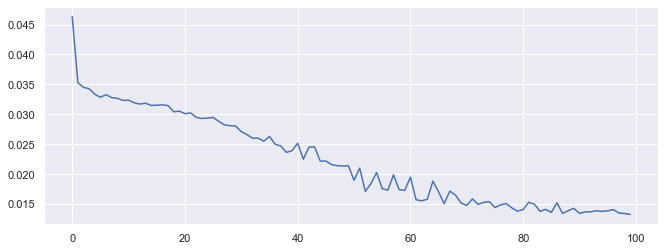

In [36]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [37]:
X.shape

(3280, 7, 1)

In [38]:
#Taking the last 7 values to make a prediction
last_train_batch = X[-7:]

In [39]:
last_train_batch.shape

(7, 7, 1)

In [40]:
last_train_batch[:,0:7,:].shape

(7, 7, 1)

In [41]:
predicted = model.predict(X)
predicted
print(predicted.shape)

(3280, 1)


In [42]:
validation_step = 7 
predictions = []

last_x = X[1770] 

for i in range(len(test_df)):
    validation_predictions = []
    while len(validation_predictions) < 7:
        p = model.predict(last_x.reshape(1, T, 1))[0,0]
        
        validation_predictions.append(p)
        
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
        
    predictions.append(validation_predictions)
    
submission_df = pd.DataFrame(predictions)
submission_df.head()

,0,1,2,3,4,5,6
0,0.588872,0.534732,0.696010,0.797968,0.862528,0.863542,0.786075
1,0.628097,0.591372,0.688370,0.803464,0.881668,0.874196,0.777510
2,0.654642,0.623591,0.699880,0.813220,0.890976,0.879498,0.783508
3,0.676937,0.649237,0.716609,0.823608,0.896726,0.884130,0.793918
4,0.697925,0.672920,0.734356,0.833593,0.901118,0.888851,0.805752


In [43]:
final_subm = scaler.inverse_transform(submission_df)
final_subm.shape

(1090, 7)

In [45]:
file1 = pd.read_csv('./Dataset/sample_submisstion.csv', index_col=0, parse_dates=False)
file1.head()

,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
Date,,,,,,,
1/1/2015,1000.5,1200.3,1300.4,1500.6,1550.8,1400.7,1586.2
1/2/2015,1000.5,1200.3,1300.4,1500.6,1550.8,1400.7,1586.2
1/3/2015,1000.5,1200.3,1300.4,1500.6,1550.8,1400.7,1586.2
1/4/2015,1000.5,1200.3,1300.4,1500.6,1550.8,1400.7,1586.2
1/5/2015,1000.5,1200.3,1300.4,1500.6,1550.8,1400.7,1586.2


In [46]:
df = pd.DataFrame(final_subm)
df.columns = file1.columns
df.index = test_df["Date"]
df.head()

,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
Date,,,,,,,
2015-01-01,1314.951904,1271.506104,1400.927856,1482.746704,1534.554932,1535.368286,1473.203369
2015-01-02,1346.428711,1316.957764,1394.796509,1487.157227,1549.913940,1543.917725,1466.329346
2015-01-03,1367.730591,1342.813354,1404.033691,1494.986084,1557.383545,1548.172974,1471.142944
2015-01-04,1385.622437,1363.393188,1417.457642,1503.322266,1561.998291,1551.890259,1479.496582
2015-01-05,1402.464600,1382.398315,1431.699829,1511.335449,1565.522339,1555.678589,1488.993042


In [47]:
df.to_csv("submission.csv")

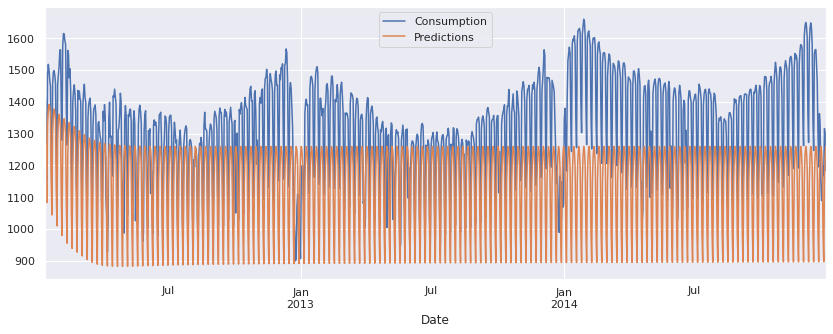

In [ ]:
validation.plot(figsize=(14,5))

In [ ]:
rmse=sqrt(mean_squared_error(validation['Consumption'], validation['Predictions']))
print(rmse)

202.3193662336248


In [ ]:
dict_keys = file1.columns
dict_keys

Index(['Consumption_day_1', 'Consumption_day_2', 'Consumption_day_3',
       'Consumption_day_4', 'Consumption_day_5', 'Consumption_day_6',
       'Consumption_day_7'],
      dtype='object')

In [ ]:
df_submission = pd.DataFrame([], columns = dict_keys, index=file1.index)
df_submission

,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
Date,,,,,,,
1/1/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/2/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/3/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/4/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/5/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12/21/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12/22/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12/23/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_submission

,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
Date,,,,,,,
1/1/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/2/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/3/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/4/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/5/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12/22/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12/23/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12/24/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
empty_list = np.array([])
for i in range(156):
  for i in range(7):
    predicted = model.predict(last_train_batch[:,i:8,:])
    empty_list = np.append(empty_list,predicted)
    last_train_batch = np.append(last_train_batch,[predicted],axis=1)

In [ ]:
empty_list = empty_list[:-2]